# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.390187,False,-1.647817
1,-0.147554,False,-1.505448
2,-0.520621,False,-0.853363
3,0.414190,True,5.713419
4,-0.170708,False,-0.062050
...,...,...,...
995,-0.325250,False,-0.834980
996,-3.086294,False,-5.348348
997,-0.118775,True,5.703203
998,-0.224990,True,4.552428


<Axes: xlabel='v0'>

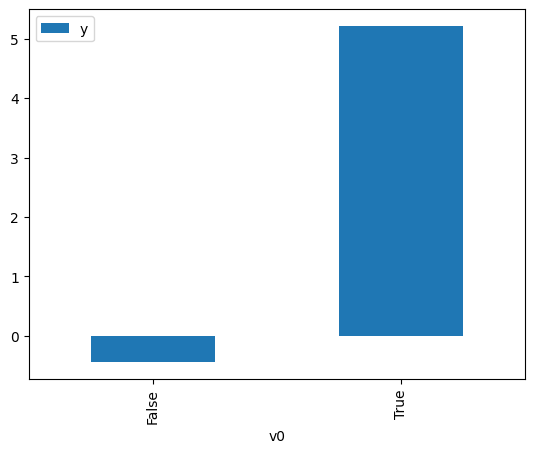

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

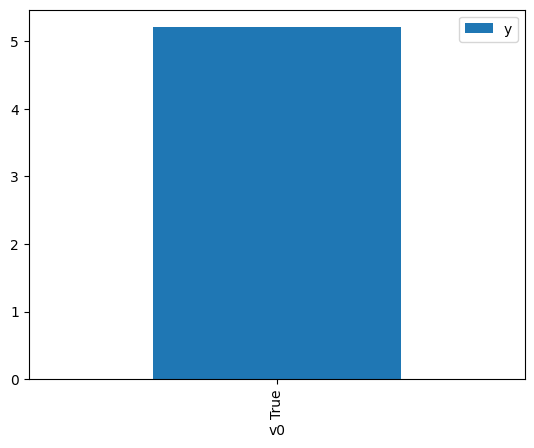

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.134778,False,-3.421123,0.923168,1.083227
1,-1.384538,False,-3.388304,0.953558,1.048703
2,-0.322242,False,-2.291400,0.677655,1.475677
3,0.011979,False,0.678539,0.506500,1.974335
4,0.196348,False,1.256967,0.408653,2.447063
...,...,...,...,...,...
995,-1.149077,False,-1.226961,0.925315,1.080713
996,-0.526597,False,-2.360688,0.765205,1.306840
997,0.215081,False,-0.345697,0.398978,2.506402
998,0.848237,False,1.325599,0.145784,6.859470


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.085579,True,5.866235,0.441446,2.265281
1,1.593489,True,9.349613,0.966653,1.034497
2,0.562513,True,6.406271,0.760438,1.315031
3,0.629654,True,5.960494,0.785688,1.272770
4,1.190431,True,6.821978,0.924295,1.081906
...,...,...,...,...,...
995,0.601161,True,5.912739,0.775215,1.289964
996,0.471905,True,6.050559,0.723262,1.382625
997,-0.442840,True,4.412772,0.268599,3.723021
998,0.975010,True,6.885725,0.884936,1.130025


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                          1.024e+04
Date:                Tue, 16 Jan 2024   Prob (F-statistic):                        0.00
Time:                        18:01:02   Log-Likelihood:                         -1401.6
No. Observations:                1000   AIC:                                      2807.
Df Residuals:                     998   BIC:                                      2817.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9387      0.031     61.613      0.000       1.877       2.000
x2             5.0721      0.050    100.562      0.000       4.973       5.171
==============================================================================
Omnibus:                        1.408   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                1.288
Skew:                          -0.080   Prob(JB):                        0.525
Kurtosis:                       3.074   Cond. No.                         1.82
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""